**Importações**

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

**Obtendo os dados**

Significado das colunas:



* PassengerId: Número de identificação do passageiro
*  Survived: Informa se o passageiro sobreviveu ao desastre
  *   0 = Não
  *   1 = Sim
*   Pclass: Classe do bilhete
  *   1 = 1ª Classe
  *   2 = 2ª Classe
  *   3 = 3ª Classe
*  Name: Nome do passageiro
*  Sex: Sexo do passageiro
*  Age: Idade do passageiro
*  SibSp: Quantidade de cônjuges e irmãos a bordo
*  Parch: Quantidade de pais e filhos a bordo
*  Ticket: Número da passagem
*  Fare: Preço da Passagem
*  Cabin: Número da cabine do passageiro
* Embarked: Porto no qual o passageiro embarcou
  * C = Cherbourg
  * Q = Queenstown
  * S = Southampton

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print('O Conjunto de dados tem %s linhas e %s colunas'%(df.shape[0], df.shape[1]))

O Conjunto de dados tem 891 linhas e 12 colunas


**Analisando os dados**

In [6]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
for col in df.columns:
  print('Total de dados nulos na coluna %s: %s'%(col,df[col].isnull().sum()))

Total de dados nulos na coluna PassengerId: 0
Total de dados nulos na coluna Survived: 0
Total de dados nulos na coluna Pclass: 0
Total de dados nulos na coluna Name: 0
Total de dados nulos na coluna Sex: 0
Total de dados nulos na coluna Age: 177
Total de dados nulos na coluna SibSp: 0
Total de dados nulos na coluna Parch: 0
Total de dados nulos na coluna Ticket: 0
Total de dados nulos na coluna Fare: 0
Total de dados nulos na coluna Cabin: 687
Total de dados nulos na coluna Embarked: 2


A coluna idade e a cabine possuem muitos dados nulos

In [13]:
print('Porcentagem de dados nulos')
((df.isnull().sum()/df.shape[0])* 100).sort_values(ascending = False)

Porcentagem de dados nulos


Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

In [29]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f53abc41e90>,
      dtype=object)

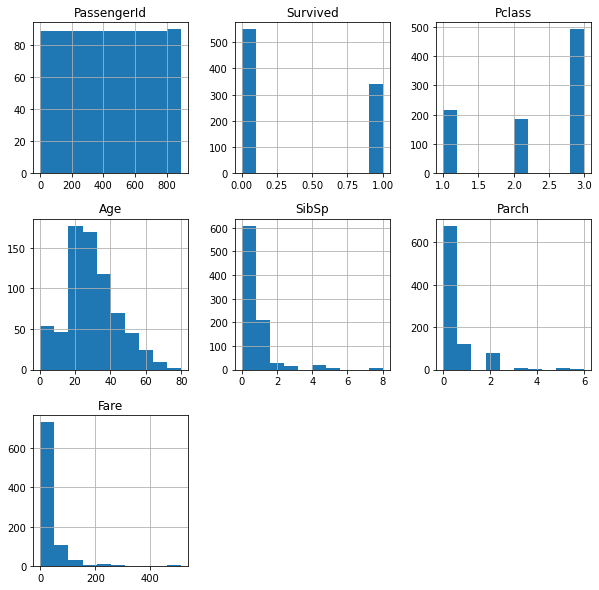

In [14]:
df.hist(figsize=(10,10))

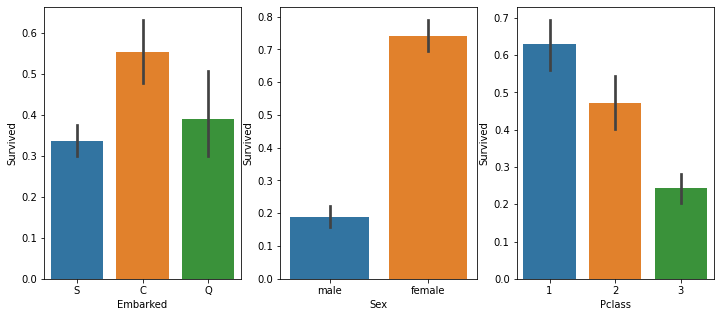

In [23]:
fig,(ax, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

sns.barplot(x = 'Embarked', y = 'Survived', data = df, ax = ax)
sns.barplot(x = 'Sex', y = 'Survived', data = df, ax = ax2)
sns.barplot(x = 'Pclass',y = 'Survived', data = df, ax = ax3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


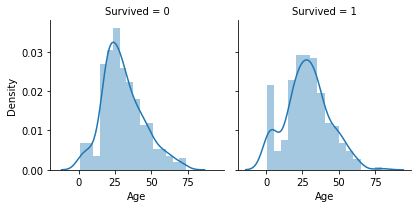

In [25]:
prob_age_survived = sns.FacetGrid(df, col = 'Survived')
prob_age_survived.map(sns.distplot, 'Age')

**Tratando os dados**

Como visto anteriormente, existem dados faltantes nas colunas Age e Embarked. Na coluna Age, irei preencher os valores nulos com a média das idades, já na coluna Embarked, irei substituir pelo porto mais frequente na base de dados

In [33]:
mean_age = df['Age'].mean()
mean_age = round(mean_age)
df['Age'].fillna(mean_age, inplace = True)

In [41]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [42]:
df['Embarked'].fillna('S', inplace = True)

In [43]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

Substituindo os valores da coluna Sex por números inteiros e criando dummies para a variável Embarked

In [66]:
dicionario = {'female': 0,'male':1}
df['Sex'] = df['Sex'].map(dicionario)

In [71]:
dummies = pd.get_dummies(df['Embarked'], prefix= 'Embarked')
df = pd.concat([df,dummies], axis = 1)

Removendo a variável Embarked pós dummies e outras que não se mostraram relevantes nas estatísticas 

In [73]:
df.drop(columns = ['Embarked','Ticket','PassengerId', 'Cabin','Name'], inplace = True)

In [74]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,0,1
1,1,1,0,38.0,1,0,71.2833,1,0,0
2,1,3,0,26.0,0,0,7.9250,0,0,1
3,1,1,0,35.0,1,0,53.1000,0,0,1
4,0,3,1,35.0,0,0,8.0500,0,0,1


**Criando o modelo**

In [76]:
def my_model(dataset,classifier, kbest = False):
  y = dataset['Survived']
  X = dataset.drop(columns = 'Survived')
  seed = 25
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = seed)

  
  model = classifier
  model.fit(X_train,y_train)

  matriz = plot_confusion_matrix(model,X_train,y_train, values_format = '.3g')
  plt.title('Matrix de confusão')
  plt.show()

  predict = model.predict(X_test)
  print('\n Classification Report:')
  print(classification_report(y_test,predict))

  prob_predict = model.predict_proba(X_test)[:,1]
  tfp,tvp,limite = roc_curve(y_test,prob_predict)
  print('roc_auc:',roc_auc_score(y_test,prob_predict))

  plt.subplots(1,figsize = (5,5))
  plt.title('Curva roc')
  plt.plot(tfp,tvp)
  plt.xlabel('Especificidade')
  plt.ylabel('Sensibilidade')
  plt.plot([0,1], ls = '--',c = 'red')
  plt.plot([0,0],[0,1], ls = '--',c = 'green'),plt.plot([1,1], ls = '--', c = 'green')
  plt.show()

  return model,matriz

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


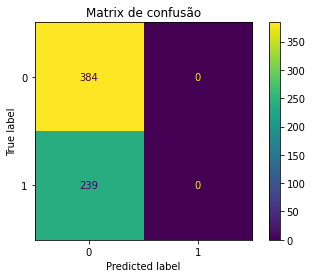


 Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       165
           1       0.00      0.00      0.00       103

    accuracy                           0.62       268
   macro avg       0.31      0.50      0.38       268
weighted avg       0.38      0.62      0.47       268

roc_auc: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


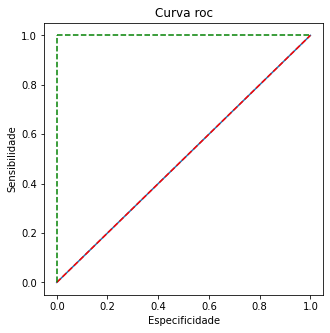

In [81]:
dc = my_model(df,DummyClassifier(strategy ="most_frequent",random_state = 25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


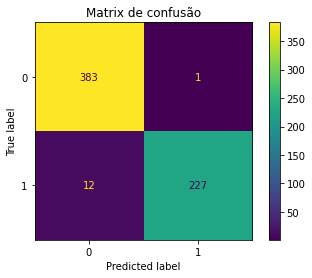


 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       165
           1       0.73      0.75      0.74       103

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.78       268
weighted avg       0.80      0.79      0.80       268

roc_auc: 0.7771109149749927


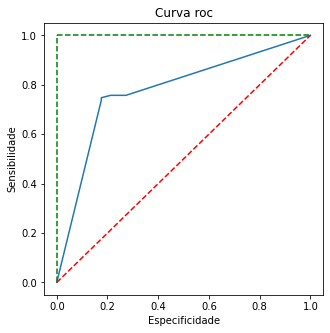

In [79]:
dt = my_model(df,DecisionTreeClassifier(random_state = 25))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


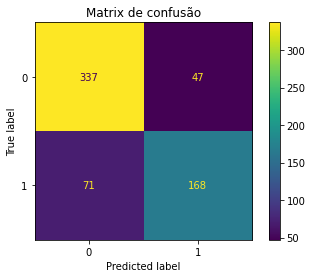


 Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       165
           1       0.73      0.69      0.71       103

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268

roc_auc: 0.85219182112386


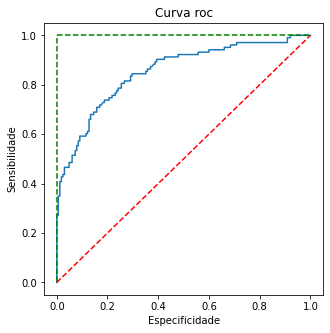

In [80]:
lg = my_model(df,LogisticRegression(max_iter=1000))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


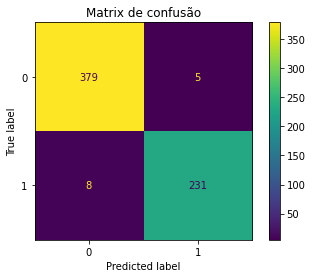


 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       165
           1       0.74      0.76      0.75       103

    accuracy                           0.80       268
   macro avg       0.79      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

roc_auc: 0.8552515445719329


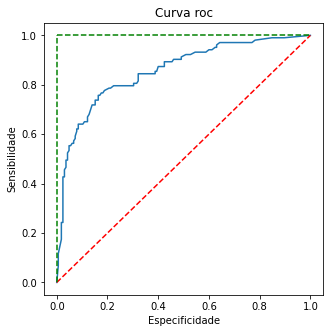

In [82]:
rf = my_model(df,RandomForestClassifier(n_estimators=100, criterion='gini',  min_samples_split=2, min_samples_leaf=1,))

**Otimizando o modelo RandomForestClassifier**

In [86]:
y = df['Survived']
X = df.drop(columns = 'Survived')
seed = 25
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state = seed)

model = RandomForestClassifier()
params = {'max_features':[0.4,'auto'],
          'n_estimators': [15,200],
          'min_samples_leaf':[1,0.1]
          }
cv = GridSearchCV(model,params,scoring='f1',n_jobs= -1)
cv.fit(X_train,y_train)
cv.best_params_

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200}

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


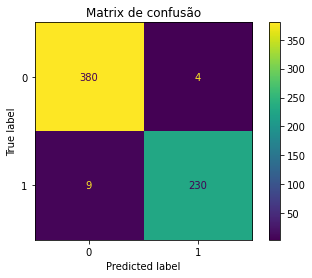


 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       165
           1       0.74      0.77      0.75       103

    accuracy                           0.81       268
   macro avg       0.79      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

roc_auc: 0.8586643130332452


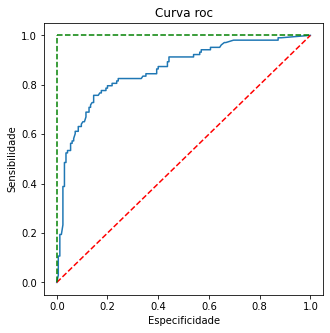

In [87]:
best_model = my_model(df,RandomForestClassifier(max_features= 0.4,min_samples_leaf= 1, n_estimators= 200))